### 데이터 불러오기

In [0]:
import numpy as np
import matplotlib.pyplot as plt

In [0]:
from tensorflow.keras.datasets import imdb

In [0]:
(X_train_all, y_train_all), (X_test, y_test) = imdb.load_data(
                                                  skip_top=20, num_words=100)

In [0]:
# 훈련셋에서 2 제외 - 0은 패딩에 사용, 1은 글의 시작을 나타내므로 삭제 안함
for i in range(len(X_train_all)):
  X_train_all[i] = [w for w in X_train_all[i] if w > 2]

In [0]:
# 어휘 사전 구축
word_to_index = imdb.get_word_index()

In [0]:
# 훈련셋의 점수를 영어 단어로 변환
index_to_word = {word_to_index[k]: k for k in word_to_index}

In [0]:
# 훈련셋과 검증셋 생성
np.random.seed(42)
random_index = np.random.permutation(25000)

X_train = X_train_all[random_index[:20000]]
y_train = y_train_all[random_index[:20000]]

X_val = X_train_all[random_index[20000:]]
y_val = y_train_all[random_index[20000:]]

In [0]:
# 리뷰의 길이가 다르므로 샘플의 길이를 맞춰줘야함
# 일정 길이를 넘기면 버리고, 부족하면 앞에 0으로 채움
from tensorflow.keras.preprocessing import sequence

maxlen = 100
X_train_seq = sequence.pad_sequences(X_train, maxlen=maxlen)
X_val_seq = sequence.pad_sequences(X_val, maxlen=maxlen)

In [0]:
# 원-핫 인코딩
from tensorflow.keras.utils import to_categorical

X_train_onehot = to_categorical(X_train_seq)
X_val_onehot = to_categorical(X_val_seq)

### 텐스플로우를 이용한 순환 신경망(RNN)

In [0]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN

In [0]:
model = Sequential()

In [0]:
# 셀의 개수, (타임스텝의 길이, 원-핫 인코딩의 크기)
model.add(SimpleRNN(32, input_shape=(100, 100)))

# 이진분류를 사용하므로 1개의 유닛을 가짐
model.add(Dense(1, activation='sigmoid'))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 32)                4256      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 4,289
Trainable params: 4,289
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
hist = model.fit(
    X_train_onehot, y_train, epochs=20, batch_size=32, 
    validation_data=(X_val_onehot, y_val)
)

**손실 & 정확도 그래프**

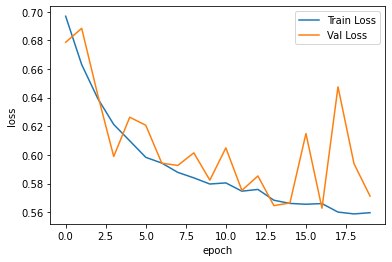

In [19]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train Loss', 'Val Loss'])
plt.show()

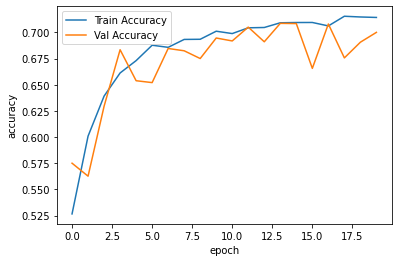

In [20]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train Accuracy', 'Val Accuracy'])
plt.show()

**단어 임베딩으로 단어 사이의 연관성까지 고려하기**
- 원-핫 인코딩
  - 단어 사이의 유사성 표현 불가
- 단어 임베딩
  - 단어 사이의 유사성 표현 가능

In [0]:
(X_train_all, y_train_all), (X_test, y_test) = imdb.load_data(
                                                  skip_top=20, num_words=1000)

In [0]:
for i in range(len(X_train_all)):
  X_train_all[i] = [w for w in X_train_all[i] if w > 2]

In [0]:
X_train = X_train_all[random_index[:20000]]
y_train = y_train_all[random_index[:20000]]

X_val = X_train_all[random_index[20000:]]
y_val = y_train_all[random_index[20000:]]

In [0]:
maxlen = 100
X_train_seq = sequence.pad_sequences(X_train, maxlen=maxlen)
X_val_seq = sequence.pad_sequences(X_val, maxlen=maxlen)

In [0]:
# 모델 생성
from tensorflow.keras.layers import Embedding

model = Sequential()
model.add(Embedding(1000, 32))
model.add(SimpleRNN(8))
model.add(Dense(1, activation='sigmoid'))

In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          32000     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 8)                 328       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 32,337
Trainable params: 32,337
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
hist = model.fit(X_train_seq, y_train, epochs=20, batch_size=32,
                 validation_data=(X_val_seq, y_val))

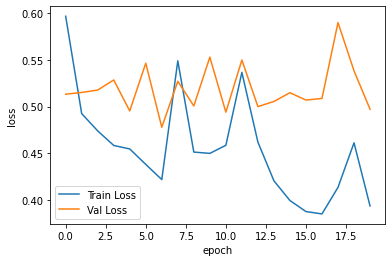

In [28]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train Loss', 'Val Loss'])
plt.show()

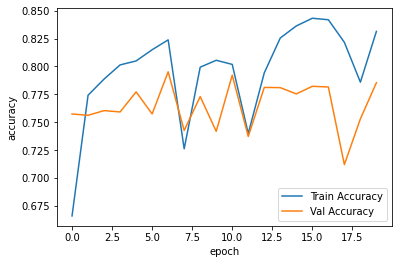

In [29]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train Accuracy', 'Val Accuracy'])
plt.show()

### LSTM 순환 신경망으로 텍스트 분류

- LSTM 순환 신경망
  - 그레디언트가 타임 스텝 끝까지 전파되도록 하는 순환 신경망
- 순환 신경망의 문제점
  - 그레디언트가 타임 스텝을 거슬러가면서 전파될 때, 가중치가   
  반복적으로 곱해져서 그레디언트가 크게 증가하거나 감소하는 현상 발생
- LSTM 셀 구조
  - 2개의 출력이 순환되는 구조
  - 셀로만 순환되는 출력을 셀 상태(C)라고 함
- LSTM 셀의 계산 구조
  - F(forget gate): 이전 셀 상태의 내용을 삭제하는 역할
  - I(input gate): 새로운 정보를 추가하는 역할

In [0]:
from tensorflow.keras.layers import LSTM

model = Sequential()
model.add(Embedding(1000, 32))
model.add(LSTM(8))
model.add(Dense(1, activation='sigmoid'))

In [36]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          32000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 1312      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 33,321
Trainable params: 33,321
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
hist = model.fit(X_train_seq, y_train, epochs=20, batch_size=32,
                 validation_data=(X_val_seq, y_val))

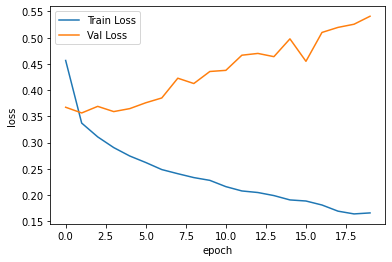

In [38]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train Loss', 'Val Loss'])
plt.show()

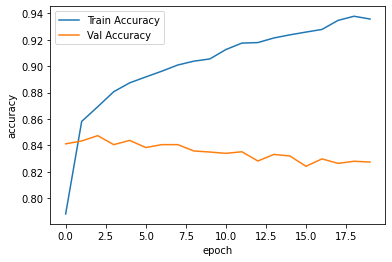

In [39]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train Accuracy', 'Val Accuracy'])
plt.show()